In [13]:
import sys
from typing import List, Dict, Tuple, Any

In [14]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [17]:
log_file_path = "exp/fedavg_sasrec_on_sr_data_lr0.001_lstep60/normbounding_bandwagon_attack_0430_byzantine_250/exp_print.log"
log_content = load_log_file(log_file_path)

SyntaxError: EOL while scanning string literal (787058518.py, line 1)

In [16]:
## Federated Learning Infos
import ast

federated_configuration = {}

federated_configuration["client_num"] = ast.literal_eval(log_content.split('client_num: ')[1].split('\n')[0]) ## To int
federated_configuration["attacker_id"] = ast.literal_eval(log_content.split('attacker_id: ')[1].split('\n')[0]) ## To list
federated_configuration["total_round_num"] = ast.literal_eval(log_content.split('total_round_num: ')[1].split('\n')[0]) ## To int
federated_configuration["sample_client_num"] = ast.literal_eval(log_content.split('sample_client_num: ')[1].split('\n')[0]) ## To int
federated_configuration["local_update_steps"] = ast.literal_eval(log_content.split('local_update_steps: ')[2].split('\n')[0]) ## To int

print(federated_configuration)

IndexError: list index out of range

In [ ]:
import ast
local_results = log_content.split('(client:354)')[1:]
refined_local_results = []  

for local_result in local_results :
    refined_str = local_result.split('\n')[0]
    refined_str = refined_str.split('INFO: ')[1]
    refined_dict = ast.literal_eval(refined_str)
    refined_local_results.append(refined_dict)
    
print(refined_local_results[0]['Round'])
print(refined_local_results[-1])


0
{'Role': 'Client #2966', 'Round': 199, 'Results_raw': {'train_loss': 245.579079, 'train_total': 60, 'train_avg_loss': 4.092985, 'train_poison_recall_10': None, 'train_poison_recall_20': None, 'train_poison_recall_50': None, 'train_poison_ndcg_10': None, 'train_poison_ndcg_20': None, 'train_poison_ndcg_50': None, 'train_recall_10': 0.933333, 'train_recall_20': 0.966667, 'train_ndcg_10': 0.75459, 'train_ndcg_20': 0.76295}}


In [ ]:
## segregate attacker and non-attacker clients

benign_clients_result = []
malicious_clients_result = []

def parse_client_id(role : str) -> int :
    """
    Parse the client id from the role string such as 'Client #593'.
    """
    return int(role.split('#')[1])

for local_result in refined_local_results:
    current_id = parse_client_id(local_result['Role'])
    
    if current_id in federated_configuration["attacker_id"]:
        malicious_clients_result.append(local_result)
    else:
        benign_clients_result.append(local_result)

print(len(malicious_clients_result))
print(len(benign_clients_result))


0
40000


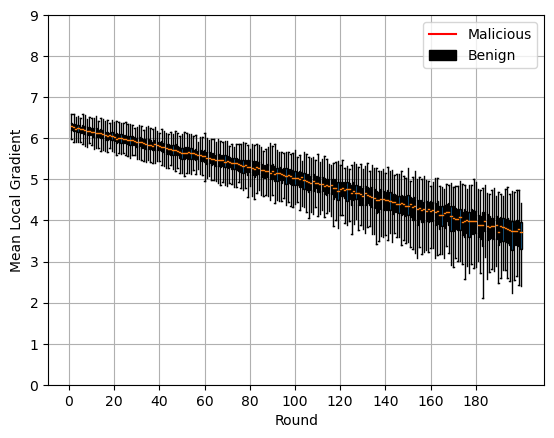

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

## x-axis : round, y-axis : gradient mean, std, max, min

## for each round gradient values are
benign_gradients = {i : [] for i in range(federated_configuration["total_round_num"])}
malicious_gradients = {i : [] for i in range(federated_configuration["total_round_num"])}

for local_result in benign_clients_result:
    current_round = local_result['Round']
    benign_gradients[current_round].append(local_result['Results_raw']['train_avg_loss'])
    
for local_result in malicious_clients_result:
    current_round = local_result['Round']
    malicious_gradients[current_round].append(local_result['Results_raw']['train_avg_loss'])

benign_datas = [value for key, value in benign_gradients.items()]

fig, ax = plt.subplots()

benign_boxplot = ax.boxplot(benign_datas, showfliers=False, patch_artist=True, vert=True, labels=benign_gradients.keys(), manage_ticks=False)


mean_malicious_gradients = np.zeros((federated_configuration["total_round_num"]))
for round, gradients in malicious_gradients.items():
    if len(gradients) == 0:
        mean_malicious_gradients[round] = np.nan
    else: 
        mean_malicious_gradients[round] = np.mean(gradients)

malicious_line_plot = ax.plot(mean_malicious_gradients, label='Malicious', color='red')

plt.xlabel('Round')
ax.set_xticks(np.arange(0, federated_configuration["total_round_num"], 20))
ax.grid(True)
plt.ylabel('Mean Local Gradient')

handles, labels = ax.get_legend_handles_labels()
empty_boxplot_label = mpatches.Patch(color='black', label='Benign')
handles.extend([empty_boxplot_label]) 
ax.legend(handles=handles)
ax.set_ylim(0, 9)

plt.show()





In [ ]:
import numpy as np

## Sample random 250 client ids from all 6040 users. 
## 1 ~ 6040

random_ids = np.random.randint(1, 6040, 250)
random_ids = np.sort(random_ids)

result_string = "["
for client_id in random_ids:
    result_string += str(client_id) + ", "

result_string = result_string[:-2] + "]"    

print(result_string)

[6, 33, 75, 76, 96, 142, 147, 175, 193, 262, 273, 273, 318, 399, 406, 411, 415, 508, 537, 540, 555, 601, 651, 683, 684, 694, 739, 753, 763, 826, 938, 971, 1017, 1100, 1105, 1118, 1134, 1191, 1196, 1213, 1244, 1254, 1263, 1280, 1304, 1304, 1319, 1344, 1364, 1390, 1403, 1410, 1415, 1417, 1440, 1469, 1478, 1481, 1496, 1510, 1534, 1556, 1638, 1701, 1768, 1810, 1811, 1812, 1832, 1880, 1929, 1934, 1965, 1972, 1984, 2000, 2018, 2019, 2037, 2067, 2105, 2110, 2111, 2111, 2216, 2240, 2278, 2289, 2291, 2295, 2329, 2343, 2363, 2374, 2398, 2410, 2418, 2480, 2480, 2497, 2525, 2548, 2574, 2588, 2611, 2617, 2653, 2665, 2697, 2700, 2789, 2811, 2819, 2840, 2961, 2991, 2996, 3025, 3064, 3066, 3106, 3117, 3130, 3139, 3177, 3177, 3210, 3212, 3242, 3244, 3283, 3366, 3378, 3395, 3402, 3424, 3438, 3454, 3456, 3476, 3497, 3539, 3544, 3548, 3575, 3576, 3588, 3618, 3620, 3649, 3654, 3659, 3693, 3728, 3741, 3747, 3754, 3757, 3800, 3842, 3843, 3843, 3891, 3910, 3923, 3924, 3989, 4040, 4040, 4046, 4066, 4117, 4125,